In [33]:
from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import JLKiss64RandEngine
from matplotlib import pyplot as plt
import math
import numpy as np


class CardShuffleChoice:
    EPSILON = 0.01
    SCALE = 100000
    
    def __init__(self, symbols: list, possibilities: list, gen, default_scale=SCALE):
        self.gen = gen
        self.cards = []
        
        for i in range(len(possibilities)):
            number = possibilities[i] * default_scale

            for j in range(int(number)):
                self.cards.append(symbols[i])

    def next(self):
        next_id = self.gen.next() % len(self.cards)

        return self.cards[next_id]

In [34]:
def get_bins_count(n):
    if n <= 100:
        return int(np.sqrt(n))
    else:
        return 10 * int(np.log10(n))

_lambda = 2
n = 10000
segments = get_bins_count(n)

In [35]:
def poisson_distrib(_lambda: int, k: int) -> list:
    poisson = []
    for i in range(k):
        poisson.append(math.exp(-_lambda) * _lambda**i/ math.factorial(i))
    return poisson

values = [i for i in range(1, 11)]
possibilities = poisson_distrib(_lambda, 10)

gen = BasicRand(JLKiss64RandEngine())
card_shuffle = CardShuffleChoice(values, possibilities, gen)

def build_sample(n):
    res = []
    for i in range(n):
        res.append(card_shuffle.next())

    x_var = sorted(res)
    return x_var

x_var = build_sample(n)

### Равноинтервальная гистограмма

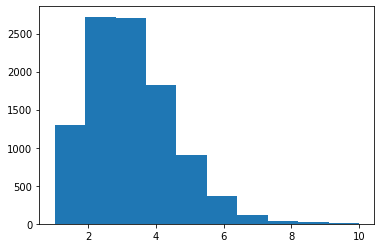

In [36]:
vals, bins, _ = plt.hist(x_var)

### Равновероятностная гистограмма

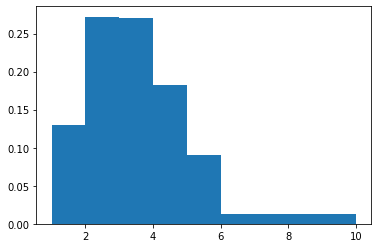

In [37]:
borders_eq = [x_var[0]] + [(x_var[i] + x_var[i + 1]) / 2 for i in range(n // segments - 1, n - 1, n // segments)] + [x_var[-1]]

vals_int, bins_int, patches_int = plt.hist(x_var, bins=borders_eq, density=True)

### Найдем точечное значение матожидания случайной величины

In [38]:
m_p = np.sum(x_var) / n
print(m_p)

3.0189


### Найдем точечное значение дисперсии случайной величины

In [39]:
d_p = np.sum((x_var - m_p)**2) / (n - 1)
print(d_p)

2.0351463046304628


In [40]:
import scipy.stats

laplace = [(x, scipy.stats.norm.cdf(x) - 0.5) for x in np.arange(0, 5, 0.01)]

def find_x_laplace(u):
    good_x = 0
    min_d = 10
    for x, y in laplace:
        if abs(u - y) < min_d:
            min_d = abs(u - y)
            good_x = x
    return good_x

print(find_x_laplace(0.4418))

1.57


### Построим график зависимости величины интервала для матожидания от значимости при точечной оценке

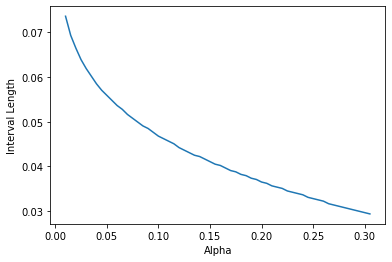

In [41]:
def get_interval(s, val, n):
    return s * find_x_laplace(val) / np.sqrt(n)

alphas = np.arange(0.01, 0.31, 0.005)
laplaces = (1 - alphas) / 2
lens = []
for i in range(len(laplaces)):
    interval_len = 2 * get_interval(np.sqrt(d_p), laplaces[i], n)
    lens.append(interval_len)

plt.ylabel('Interval Length')
plt.xlabel('Alpha')
plt.plot(alphas, lens)

plt.show()

### Довериетельный интервал для дисперсии

In [42]:
from scipy.stats import chi2

In [43]:
def get_dispersion_intervals(s_sqr, alpha, n):
    return s_sqr * (n - 1) / chi2.ppf(1 - alpha / 2, n - 1), s_sqr * (n - 1) / chi2.ppf(alpha / 2, n - 1)

def get_dispersion_intervals_known(s_sqr, alpha, n):
    return s_sqr * n / chi2.ppf(1 - alpha / 2, n), s_sqr * n / chi2.ppf(alpha / 2, n)

def build_solution_dispersion(n):
    x_var = build_sample(n)
    m_p = np.sum(x_var) / n
    d_p = np.sum((x_var - m_p)**2) / (n - 1)
    alphas = np.arange(0.01, 0.31, 0.005)
    lens = []
    for i in range(len(laplaces)):
        l, r = get_dispersion_intervals(d_p, alphas[i], n)
        lens.append(r - l)

    plt.title('n = {0}'.format(n))
    plt.ylabel('Interval Length')
    plt.xlabel('Alpha')
    plt.plot(alphas, lens)
    
    plt.show()

In [44]:
from ipywidgets import interact, IntSlider

In [45]:
interact(build_solution_dispersion, n=IntSlider(min=30, max=150, step=10, value=30));

interactive(children=(IntSlider(value=30, description='n', max=150, min=30, step=10), Output()), _dom_classes=…

### Проверим критерий согласия Пиррсона

In [55]:
def get_F(lambda_):
    def F(x):
        x = int(x)
        return math.exp(-_lambda) * _lambda**x / math.factorial(x)
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(int(bins[0]), int(bins[-1])):
        pi_s = F(i)
        pi = vals[i] / n
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)

In [56]:
from scipy.stats import chi2

chi_sqr = pearson_chi(bins, vals, get_F(_lambda))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')

0.2706705664732254 0.2721
0.2706705664732254 0.2707
0.1804470443154836 0.1822
0.0902235221577418 0.091
0.03608940886309672 0.0359
0.012029802954365574 0.0116
0.0034370865583901638 0.0037
0.0008592716395975409 0.0018
0.00019094925324389798 0.0006
Experimental chi square: 0.00920843455066881, Table chi square: 4.574813079322224
Good


In [48]:
vals

array([1304., 2721., 2707., 1822.,  910.,  359.,  116.,   37.,   18.,
          6.])